In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from numpy import random
from InflGame.adaptive.visualization import Shell
from InflGame.utils.general import *
from InflGame.domains.rd import*

[1, 1]

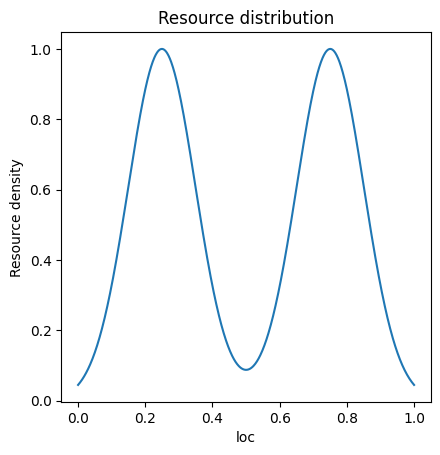

In [2]:
#The resource points
bin_points=np.linspace(.001, .999, 1000)
 
#Resource parameters
resource_parameters_gaussian=[[.1,.1],[.25,.75],[1,1]] #[[sd1, sd2,], [mean1,mean2], [factor1,factor2]]
#actual resource distribution
resource_distribution2=resource_distribution_choice(bin_points=bin_points,resource_type='multi_modal_gaussian_distribution_1D',resource_parameters=resource_parameters_gaussian)
domain=bin_points
fig, ax = plt.subplots()
ax.plot(domain,resource_distribution2)
plt.title('Resource distribution')
plt.xlabel('loc')
plt.ylabel('Resource density')
ax.set_box_aspect(1) 
fig.savefig('1d_bimodal_alpha_05.svg',bbox_inches='tight')
resource_parameters_gaussian[2]

In [124]:
from scipy.special import gamma

def custom_influence_1d(x_torch, bin_points, parameter_instance):
    # Here is an example with chi^2 inverse influence kernels in the custom format
    if not torch.is_tensor(x_torch):
        x_torch = torch.tensor(x_torch, dtype=torch.float32)
    if not torch.is_tensor(bin_points):
        bin_points = torch.tensor(bin_points, dtype=torch.float32)
    if not torch.is_tensor(parameter_instance):
        parameter_instance = torch.tensor(parameter_instance, dtype=torch.float32)
   
    
    # Reshape for broadcasting: 
    # agents_pos: (N,) -> (N, 1)
    # bin_points: (K,) -> (1, K)  
    # parameters: (N,) -> (N, 1)
    agents_expanded = x_torch.unsqueeze(-1)  # Shape: (N, 1)
    bins_expanded = bin_points.unsqueeze(0)    # Shape: (1, K)
    params_expanded = parameter_instance.unsqueeze(-1)  # Shape: (N, 1)
    
    # Vectorized computation: (N, 1) - (1, K) = (N, K)
    diff_squared = (bins_expanded - agents_expanded) ** 2
    variance = 2 * params_expanded ** 2
    
    # Compute influence matrix: (N, K)
    influence_matrix = torch.exp(-diff_squared / variance)
    
    return influence_matrix


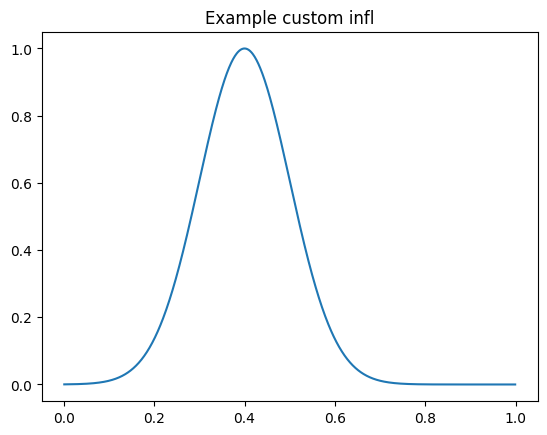

In [125]:
x=np.array([.4,.5,.6])
scale=np.array([0.1,0.1,0.1])
y=custom_influence_1d(x_torch=x,bin_points=bin_points,parameter_instance=scale)
plt.plot(bin_points,y[0])
plt.title("Example custom infl")
plt.show()

In [129]:
domain_type='1d'
resource_distribution=resource_distribution2
mean=np.dot(bin_points,resource_distribution)/np.sum(resource_distribution) #mean of the resource distribution


num_agents=3#number of agents
int_agents_pos=agent_position_setup(num_agents=num_agents,setup_type='initial_symmetric_setup',domain_type=domain_type,domain_bounds=0)
int_agents_pos= np.array([.4,.5,.6])

infl_configs={"infl_type":"custom",'custom_influence':custom_influence_1d} # influence type of the agents


parameters=np.array([0.5,0.5,0.5])# parameters impacting agents reach (their std)
#parameters_custom=np.array([[.1,.2,.3,...]]) #needs to be length num_players

learning_rate_type='cosine_annealing' 
learning_rate=[1/100000,1/1000000,2000]
#learning_rate=1/1000
time_steps=10000 # number steps for the adaptive dynamics


vis=Shell(num_agents=num_agents, agents_pos=int_agents_pos.copy(), parameters=parameters,resource_distribution=resource_distribution,bin_points=bin_points,mean=mean,infl_configs=infl_configs,learning_rate_type=learning_rate_type,learning_rate=learning_rate,time_steps=time_steps,domain_type=domain_type,tolerated_agents=None)

C:\Users\Mark-Fu-Lab\AppData\Local\Temp\ipykernel_58780\805570097.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  mean=np.dot(bin_points,resource_distribution)/np.sum(resource_distribution) #mean of the resource distribution


In [130]:
vis.setup_adaptive_env()
vis.field.gradient_ascent()
og_pos_matrix=vis.field.pos_matrix
og_grad_matrix=vis.field.grad_matrix
vis.agents_pos=int_agents_pos.copy()
vis.field.agents_pos=int_agents_pos.copy()

In [131]:
1/1.5

0.6666666666666666

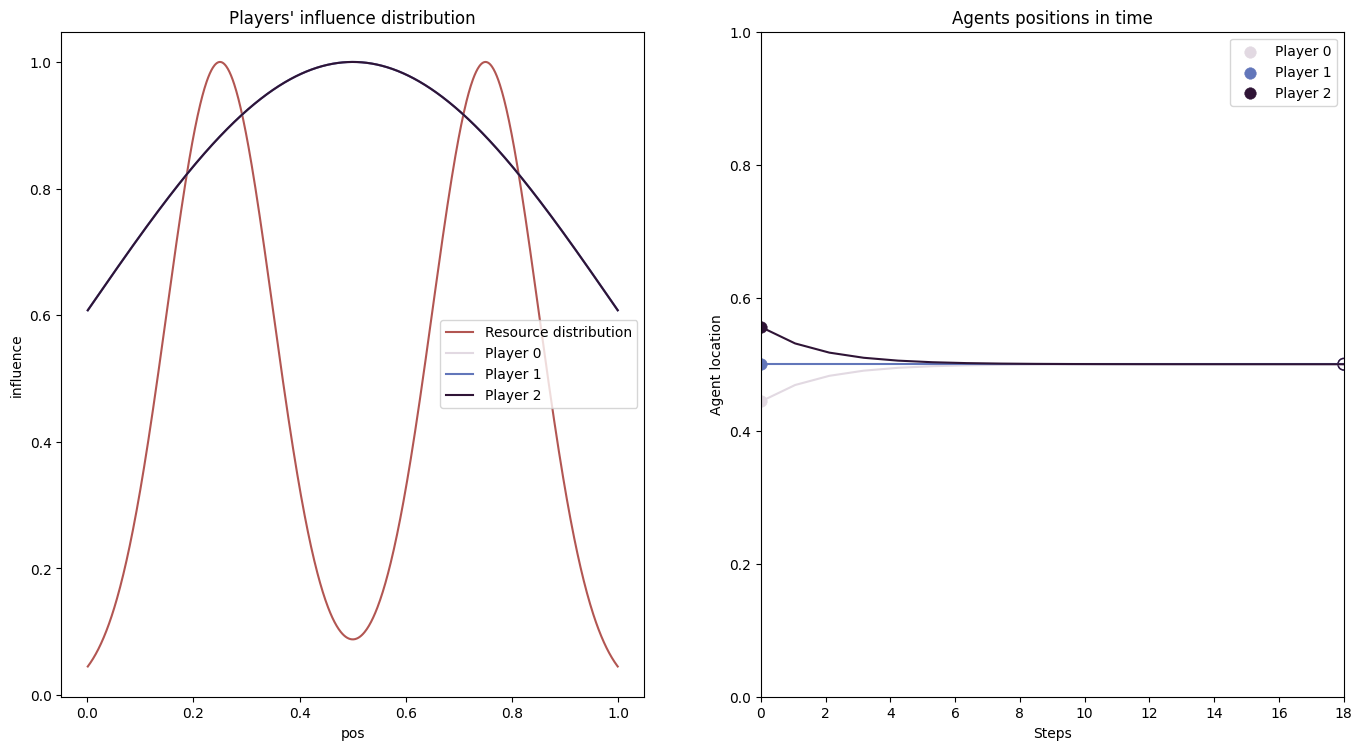

In [132]:
vis.dist_pos_gif(1)